In [1]:
import re
import pandas as pd
from dateutil.parser import parse
from textblob import TextBlob

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
from sklearn.metrics import mean_squared_error


## News sentiment analysis and feature extraction

In [2]:
dataset = pd.read_csv("data/reuters_archive_23-22.csv")
dataset.dropna(inplace=True)
dataset

,title,date,text,href
0,Elon Musk seeks to end $258 billion Dogecoin l...,Mar 31 2023,Elon Musk asked a U.S.\njudge on Friday to thr...,/article/tesla-musk-dogecoin-lawsuit/elon-musk...
1,Fed's Waller: US inflation can drop without mu...,Mar 31 2023,U.S. Federal Reserve\nGovernor Christopher Wal...,/article/usa-fed-waller/feds-waller-us-inflati...
2,Bed Bath & Beyond is sued by ousted CEO over u...,Mar 31 2023,Bed Bath & Beyond Inc\nwas sued on Friday by M...,/article/bed-bath-ceo-lawsuit/bed-bath-beyond-...
3,DIARY-Top Economic Events to May 31,Mar 31 2023,Today in Washington\n-------------------------...,/article/diary-top-econ/diary-top-economic-eve...
4,UPDATE 1-US bank deposit outflows decelerated ...,Mar 31 2023,Deposits at all U.S. commercial\nbanks fell in...,/article/usa-fed-bank-credit/update-1-us-bank-...
...,...,...,...,...
42554,GLOBAL MARKETS-Asian shares down as Alibaba's ...,Nov 18 2021,Asian shares fell on Friday as\ndisappointing ...,/article/global-markets/global-markets-asian-s...
42555,EMERGING MARKETS-S.Korean won leads most Asian...,Nov 18 2021,The following table shows rates for Asian\ncur...,/article/emerging-markets-asia/emerging-market...
42556,FACTBOX-Rival estimates on the cost of Biden's...,Nov 18 2021,Democrats in the U.S. House\nof Representative...,/article/usa-biden-infrastructure-costs/factbo...
42557,Rare copy of U.S. Constitution sells for $41 m...,Nov 18 2021,A rare copy of the U.S.\nConstitution sold for...,/article/auction-constitution-document-sale/ra...


In [3]:
# Function to check if the news is related to the financial instrument
# Set company_keywords and/or region_keywords
company_keywords = ["Apple", "AAPL", "iPhone", "Tim Cook"]
region_keywords = {
    "USA": ["America", "USA", "United States"],
    "UK": ["Great Britain", "UK", "United Kingdom"],
    "Japan": ["Japan", "Japanese", "Asia", "Asian"],
    "Europe": ["Europe", "EU", "European Union"],
    "Australia": ["Australia", "Australian"]
}

def is_related(text, keywords):
    text_lower = text.lower()
    for keyword in keywords:
        if keyword.lower() in text_lower:
            return True
    return False

# Function to extract dates from text
# Define date patterns
days_of_week = [r'\b(?:Mon(?:day)?|Tue(?:sday)?|Wed(?:nesday)?|Thu(?:rsday)?|Fri(?:day)?|Sat(?:urday)?|Sun(?:day)?)\b']
months = [r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\b']
date_formats = [r'\b\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4}\b', r'\b\d{2,4}[-/.]\d{1,2}[-/.]\d{1,2}\b']

def extract_dates(text, days_of_week, months, date_formats):
    extracted_dates = []
    for pattern in days_of_week + months + date_formats:
        matches = re.findall(pattern, text)
        for date in matches:
            try:
                parsed_date = parse(date, fuzzy=True).strftime('%Y-%m-%d')
                extracted_dates.append(parsed_date)
            except ValueError:
                # Ignore invalid date formats
                pass
    return extracted_dates

# Function to calculate sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity


In [4]:
# Filter AAPL related text (example)
dataset["AAPL_related"] = dataset["title"].apply(lambda x: is_related(x, company_keywords))

# Calculate sentiment for related text
dataset["sentiment"] = dataset["text"].apply(get_sentiment)

# Extract dates from related news
dataset["extracted_dates"] = dataset["text"].apply(lambda x: extract_dates(x, days_of_week, months, date_formats))

# Add columns for region information
for region, keywords in region_keywords.items():
    dataset[f"{region}_related"] = dataset["text"].apply(lambda x: is_related(x, keywords))


In [5]:
dataset.head()

,title,date,text,href,AAPL_related,sentiment,extracted_dates,USA_related,UK_related,Japan_related,Europe_related,Australia_related
0,Elon Musk seeks to end $258 billion Dogecoin l...,Mar 31 2023,Elon Musk asked a U.S.\njudge on Friday to thr...,/article/tesla-musk-dogecoin-lawsuit/elon-musk...,False,0.000000,[2023-04-14],False,False,False,False,False
1,Fed's Waller: US inflation can drop without mu...,Mar 31 2023,U.S. Federal Reserve\nGovernor Christopher Wal...,/article/usa-fed-waller/feds-waller-us-inflati...,False,0.043519,[2023-04-14],False,False,False,False,False
2,Bed Bath & Beyond is sued by ousted CEO over u...,Mar 31 2023,Bed Bath & Beyond Inc\nwas sued on Friday by M...,/article/bed-bath-ceo-lawsuit/bed-bath-beyond-...,False,-0.266667,"[2023-04-14, 2023-06-11]",False,False,False,False,False
3,DIARY-Top Economic Events to May 31,Mar 31 2023,Today in Washington\n-------------------------...,/article/diary-top-econ/diary-top-economic-eve...,False,0.068182,[],False,False,False,False,False
4,UPDATE 1-US bank deposit outflows decelerated ...,Mar 31 2023,Deposits at all U.S. commercial\nbanks fell in...,/article/usa-fed-bank-credit/update-1-us-bank-...,False,-0.113333,"[2023-03-11, 2023-08-11]",False,False,False,False,False


## Feature testing: EUR/USD, dayly prices, 2021 year

In [6]:
# import prices 

df = pd.read_pickle( "data/EUR_USD_D.pkl" )
not_num_cols = ['volume','time']
num_col = [x for x in df.columns if x not in not_num_cols ]

df[num_col] = df[num_col].apply(pd.to_numeric)

df.index = pd.to_datetime(df["time"], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.strftime('%Y-%m-%d')

df['Spr'] = (df.ask_c - df.bid_c)

df.rename(columns = {'volume':'Volume','mid_o':'Open','mid_c':'Close','mid_l':'Low','mid_h':'High','time':'Date'}, inplace=True)

df = df.drop(['bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c'],axis=1)

print(len(df))
print(df.columns)

4316
Index(['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'Spr'], dtype='object')


In [7]:
# Function to get the maximum/minimal sentiment for each day by region

def min_max_sentiment(array):
    # compares absolute values of min and max and return the highest with a right sign
    return max(array, default=0) if abs(max(array, default=0)) > abs(min(array, default=0)) else min(array, default=0)

def max_sentiment_by_region(dataset, region_1, region_2):
    # group news by days and return min_max_sentiment related to each region
    grouped_data = dataset.groupby("date").agg(
        EU_related_news=pd.NamedAgg(column="sentiment", aggfunc=lambda x: min_max_sentiment(x.loc[dataset.loc[x.index, region_1]])),
        USA_related_news=pd.NamedAgg(column="sentiment", aggfunc=lambda x:  min_max_sentiment(x.loc[dataset.loc[x.index, region_2]])),
    ).reset_index()

    return grouped_data

In [8]:
# Convert the date columns to a df date format
EUR_USD_news = max_sentiment_by_region(dataset, "Europe_related", "USA_related")
EUR_USD_news["date"] = pd.to_datetime(EUR_USD_news["date"], format='%b %d %Y').dt.strftime('%Y-%m-%d')
EUR_USD_news.index = EUR_USD_news["date"]

EUR_USD_news.head()

,date,EU_related_news,USA_related_news
date,,,
2022-04-01,2022-04-01,0.225000,0.294724
2022-04-02,2022-04-02,0.000000,0.000000
2022-04-03,2022-04-03,0.068056,0.000000
2022-04-04,2022-04-04,0.500000,0.390000
2022-04-05,2022-04-05,0.325000,0.250000


In [9]:
# Merge the datasets
merged_data = pd.merge(df, EUR_USD_news[["date","EU_related_news", "USA_related_news"]], left_index=True, right_index=True, how='left')
merged_data.dropna( inplace=True )

# Calculate technical indicators 
'''
merged_data["rsi"] = ta.rsi( merged_data.Close, 14)
merged_data["ema"] = ta.ema( merged_data.Close, 14)
Stochstics = ta.stoch(close = merged_data.Close, high=merged_data.High,low=merged_data.Low, k=12, d = 3, smooth = 4)
merged_data['stoch_k'] = Stochstics.iloc[:,0]
merged_data['stoch_d'] = Stochstics.iloc[:,1]
'''
# NOT ENOUGH DATA

'\nmerged_data["rsi"] = ta.rsi( merged_data.Close, 14)\nmerged_data["ema"] = ta.ema( merged_data.Close, 14)\nStochstics = ta.stoch(close = merged_data.Close, high=merged_data.High,low=merged_data.Low, k=12, d = 3, smooth = 4)\nmerged_data[\'stoch_k\'] = Stochstics.iloc[:,0]\nmerged_data[\'stoch_d\'] = Stochstics.iloc[:,1]\n'

## LSTM regression. 3 days ahead predicition 

### 1. Data preparation

In [10]:
# Features: Closing price and news ONLY
X = merged_data[["Close", "EU_related_news", "USA_related_news"]].values

past = 8
future = 3

split_train = int(len(X)*0.8)

# TRAIN OVER THE LAST 4 YEARS 2017-201
X_train = X[ 0 : split_train,:]
X_test = X[split_train:,:]

# Scale the data
columns_to_normal = 1

if columns_to_normal > 1:
    scaler = MinMaxScaler()
    X_train[:,1:columns_to_normal] = scaler.fit_transform(X_train[:,1:columns_to_normal])
    X_test[:,1:columns_to_normal] = scaler.transform(X_test[:,1:columns_to_normal])

scaler_price = MinMaxScaler()
X_train[:,0:1] = scaler_price.fit_transform(X_train[:,0:1])
X_test[:,0:1] = scaler_price.transform(X_test[:,0:1])

X_train_blocks = []
X_test_blocks = []

Y_train_blocks = []
Y_test_blocks = []

for i in range(past,len(X_train)-future):
    X_train_blocks.append( X_train[i-past:i+1,:].copy() )
    Y_train_blocks.append( X_train[i+1:i+future+1,0].copy() )

for i in range(past,len(X_test)-future):
    X_test_blocks.append( X_test[i-past:i+1,:].copy() )
    Y_test_blocks.append( X_test[i+1:i+future+1,0].copy() )

X_train_blocks = np.array(X_train_blocks)
X_train_blocks = np.reshape(X_train_blocks, (X_train_blocks.shape[0], X_train_blocks.shape[1], X_train_blocks.shape[2] ) )

X_test_blocks = np.array(X_test_blocks)
X_test_blocks = np.reshape(X_test_blocks, (X_test_blocks.shape[0], X_test_blocks.shape[1], X_test_blocks.shape[2] ) )

Y_train_blocks = np.array(Y_train_blocks)
Y_train_blocks = np.reshape(Y_train_blocks, (Y_train_blocks.shape[0], future) )

Y_test_blocks = np.array(Y_test_blocks)
Y_test_blocks = np.reshape(Y_test_blocks, (Y_test_blocks.shape[0], future) )

print(X_test_blocks.shape)
print(X_train_blocks.shape)
print(Y_train_blocks.shape)
print(Y_test_blocks.shape)

(44, 9, 3)
(209, 9, 3)
(209, 3)
(44, 3)


### 2. Model architecture 

In [11]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
from IPython import display
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

shape = (X_test_blocks.shape[1], X_test_blocks.shape[2])
 
# LSTM model with 1 LSTM layer
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_test_blocks.shape[1], X_test_blocks.shape[2]), return_sequences=False))
model.add(Dense(units = future))

callbacks = [tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3)]

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_blocks, Y_train_blocks, epochs=25, batch_size=5, callbacks=callbacks)

2023-04-11 21:25:00.073372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 21:25:08.729275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
42/42 [==============================] - 4s 7ms/step - loss: 0.2987
Epoch 2/25
42/42 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 3/25
42/42 [==============================] - 0s 6ms/step - loss: 0.0225
Epoch 4/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0134
Epoch 5/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 6/25
42/42 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 7/25
42/42 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 8/25
42/42 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 9/25
42/42 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 10/25
42/42 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 11/25
42/42 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 12/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0059
Epoch 13/25
42/42 [=============================

### 3. Performance evaluation

In [12]:
# Make predictions
Y_train_predict = model.predict(X_train_blocks)
Y_test_predict = model.predict(X_test_blocks)

df_predictions = merged_data[['Close']].copy()

df_predictions['Close_step_1'] = df_predictions.Close.shift(-1)
df_predictions['Close_step_2'] = df_predictions.Close.shift(-2)
df_predictions['Close_step_3'] = df_predictions.Close.shift(-3)

# Invert predictions
for i in range(1,future+1):
    df_predictions['pred_'+str(i)+'_day_ahead'] = np.nan
    df_predictions['pred_'+str(i)+'_day_ahead'][past:split_train-future] = scaler_price.inverse_transform(Y_train_predict[:,i-1].reshape(-1,1)).flatten()
    df_predictions['pred_'+str(i)+'_day_ahead'][split_train+past:-future] = scaler_price.inverse_transform(Y_test_predict[:,i-1].reshape(-1,1)).flatten()
    
    train_score = np.sqrt(mean_squared_error(df_predictions['pred_'+str(i)+'_day_ahead'][ past : split_train-future], 
                                            df_predictions['Close_step_'+str(i)][ past : split_train-future]))
    
    test_score = np.sqrt(mean_squared_error(df_predictions['pred_'+str(i)+'_day_ahead'][split_train+past : -future], 
                                            df_predictions['Close_step_'+str(i)][split_train+past : -future]))
    
    print(f"Train Score step {i}: {train_score:.4f} RMSE")
    print(f"Test Score step {i}: {test_score:.4f} RMSE \n")


2/2 [==============================] - 0s 8ms/step
Train Score step 1: 0.0095 RMSE
Test Score step 1: 0.0148 RMSE 

Train Score step 2: 0.0116 RMSE
Test Score step 2: 0.0162 RMSE 

Train Score step 3: 0.0123 RMSE
Test Score step 3: 0.0179 RMSE 



In [13]:
df_predictions

,Close,Close_step_1,Close_step_2,Close_step_3,pred_1_day_ahead,pred_2_day_ahead,pred_3_day_ahead
time,,,,,,,
2021-11-18,1.12819,1.12344,1.12492,1.12008,NaN,NaN,NaN
2021-11-21,1.12344,1.12492,1.12008,1.12092,NaN,NaN,NaN
2021-11-22,1.12492,1.12008,1.12092,1.13102,NaN,NaN,NaN
2021-11-23,1.12008,1.12092,1.13102,1.12925,NaN,NaN,NaN
2021-11-24,1.12092,1.13102,1.12925,1.13392,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-12-01,1.05406,1.04948,1.04670,1.05064,1.037177,1.033832,1.034307
2022-12-04,1.04948,1.04670,1.05064,1.05552,1.036314,1.037200,1.034785
2022-12-05,1.04670,1.05064,1.05552,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='time'>

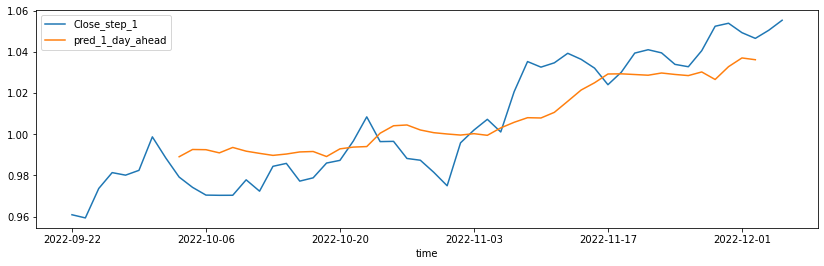

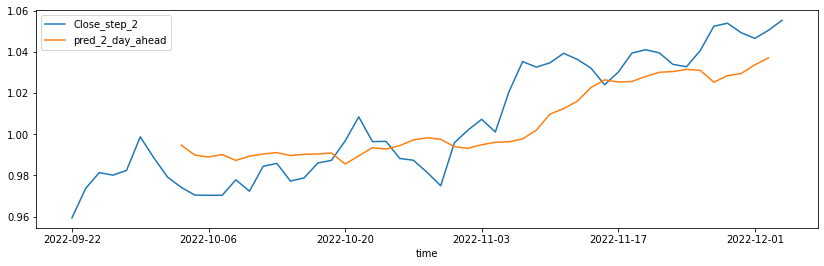

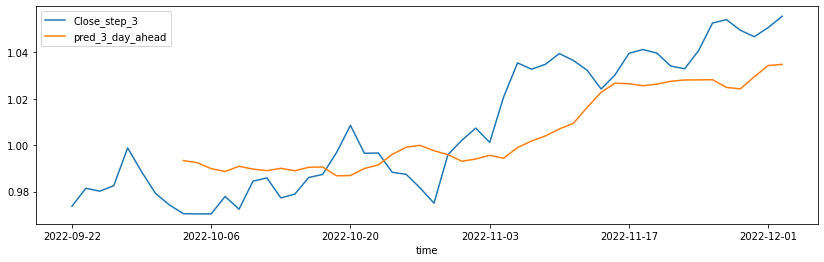

In [14]:
df_predictions[['Close_step_1','pred_1_day_ahead']][split_train : ].plot(figsize=(14,4))
df_predictions[['Close_step_2','pred_2_day_ahead']][split_train : ].plot(figsize=(14,4))
df_predictions[['Close_step_3','pred_3_day_ahead']][split_train : ].plot(figsize=(14,4))



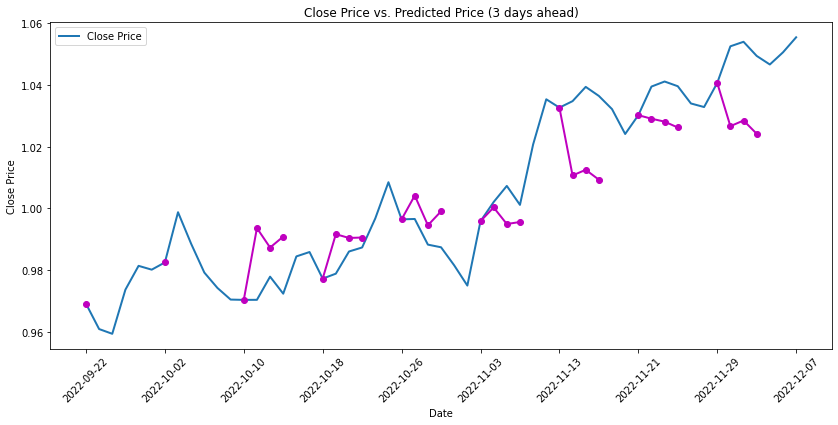

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# only test data
df_predictions['date'] = df_predictions.index
df_predictions_test = df_predictions[split_train : ]

# predictions
num_ticks = 10
ticks = np.linspace(0, len(df_predictions_test) - 1, num_ticks).astype(int)


# Create the matlib plot
plt.figure(figsize=(14, 6))
plt.plot( df_predictions_test.date, df_predictions_test.Close, lw=2, label="Close Price")
for tick in ticks[:-1]:
    x = df_predictions_test["date"][tick:tick+future+1]
    y = df_predictions_test[["Close",'pred_1_day_ahead','pred_2_day_ahead','pred_3_day_ahead']].iloc[tick]
    plt.plot( x, y, 'mo-', lw=2)

# Set x-axis ticks and labels
labels = [df_predictions_test["date"][tick] for tick in ticks]
plt.xticks(ticks, labels, rotation=45)
plt.title("Close Price vs. Predicted Price (3 days ahead)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
